In [168]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.interpolate import griddata, RectBivariateSpline
from scipy.optimize import brentq, minimize
import warnings
warnings.filterwarnings('ignore')

We are given five different strike prices and five different maturity dates and the corresponding call option prices for a non-dividend stock whose current value is 100 euros. The risk free rate is 5 percent. 

In [365]:
S=80  # Stock price
r=0.05 # Rate of interest 
y=0    # We are considering non-dividend stocks

strikes = np.array([80, 90, 100, 110, 120] * 5)
times = np.repeat([0.25, 0.5, 0.75, 1.0, 1.5], 5)  
market_prices = np.array([ 20.15, 10.52, 3.85, 5.89, 7.11,
                          20.95, 12.10, 5.87, 2.15, 0.58, 
                          21.75, 13.45, 7.55, 3.45, 1.25,
                          22.50, 14.65, 9.05, 4.75, 2.15,
                          24.25, 17.15, 11.85, 7.65, 4.75
                        ])
options=np.array(["call"]*25)

Lets create a dataframe df to store the strikes, maturities, market-prices and option type for the above data.

In [172]:
df=pd.DataFrame({"strike_price":strikes,"maturity":times, "market_price": market_prices, "option_type": options})

In [174]:
df.head()

,strike_price,maturity,market_price,option_type
0,80,0.25,20.15,call
1,90,0.25,10.52,call
2,100,0.25,3.85,call
3,110,0.25,5.89,call
4,120,0.25,7.11,call


We want to predict the option price for any strike price and maturity in this range. This is a common problem in options pricing. To do this we will invert the black-scholes model to derive the corresponding volatilities using the Newton-Rhapson's method. We will then use a interpolating function to calculate the volatility for any strike and maturity.  

Let us first write a function to define the black scholes price. 

In [367]:
def BlackScholes_price(S, K, T, r, y, sigma, option):

    d1= (np.log(S /K) + (r-y + 0.5*sigma**2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    
    if option=="call":
        price = S* np.exp(-y*T)* norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        
        price= K* np.exp(-r*T)* norm.cdf(-d2) - S* np.exp(-y*T)* norm.cdf(-d1)
       
    return price

**Newton Rhapson Method**

The Newton Rhapson method is a root finding algorithm commonly used in options pricing. This method makes use of a linear expansion of the function and relies on the analytical derivative to find the root. Given on intial guess $x_0$, one can expand 

$f(x)=f(x_0) + f^{'}(x_0)(x-x_0)$

to find 

$ x = x_0 + \frac{f(x)-f(x_0)}{f^{'}(x_0)}$

This can be thought of as a recursion relation $x_{n+1}= x_n + \frac{f(x)-f(x_n)}{f^{'}(x_n)}$ which is evaluated until it reaches the specified tolerance $\epsilon$, i.e. $|x_{n+1}-x_n|<\epsilon$ 

Our case requires the calculation of the implied volatility, where one needs the derivative of the options price w.r.t the volatility (Vega). Fortunately the analytical expression for the vega is readily available. 

In [369]:
def newton_raphson_method(market_price, strike_price, maturity, option_type, epsilon, init_vol, plot="yes"):

    num_iter=100
    
    vols=[init_vol]
    
    for i in range(num_iter):
        
        vol = init_vol + (market_price - BlackScholes_price(S, strike_price, maturity, r, y, init_vol, option_type))/vega(S, strike_price, maturity, r, y, init_vol)
        vols.append(vol)
        if abs(vol-init_vol)<epsilon:
            break
        
        init_vol=vol
    
    if plot=="yes":
        plt.figure(figsize=(5,5))

        plt.plot(np.array(range(len(vols))),np.array(vols))

        plt.xlabel("Number of iterations")
        plt.ylabel("Implied_Volatility")
        plt.title("Newton-Rhapson's convergence")

        plt.show()


    #If the algorithm does not converge return nan 
    return vol if i<num_iter-1 else np.nan

In [371]:
def vega(S, K, T, r, y, sigma):
    
    d1= (np.log(S /K) + (r-y + 0.5*sigma**2)*(T))/(sigma*np.sqrt(T))
    
    return S * np.exp(-y * T) * norm.pdf(d1) * np.sqrt(T) + 1e-5

Lets just try to plot the newton rhapson's convergence for one of the values that we have. 

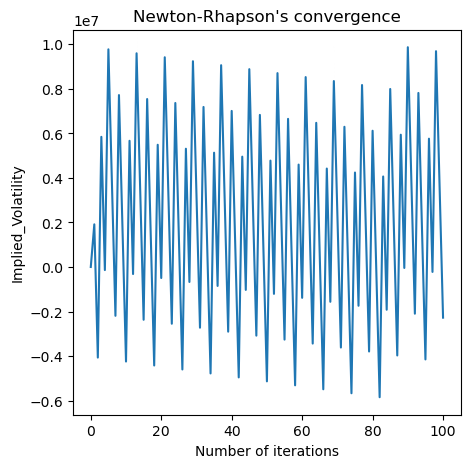

nan

In [183]:
newton_raphson_method(df.loc[0,"market_price"], df.loc[0,"strike_price"], df.loc[0,"maturity"], df.loc[0,"option_type"], 1e-4, 0.001, plot="yes")

Well it does not seem to converge for initial volatility of 0.1 percent. Lets try a higher value

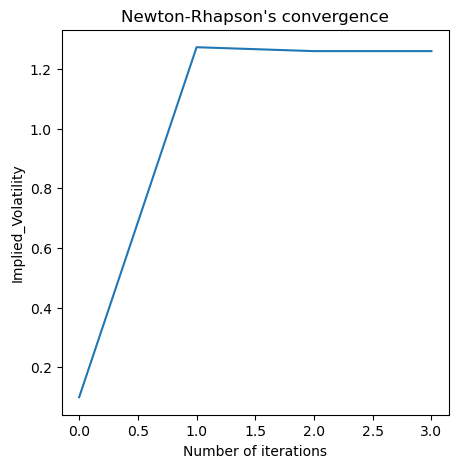

1.2595460940697045

In [186]:
newton_raphson_method(df.loc[0,"market_price"], df.loc[0,"strike_price"], df.loc[0,"maturity"], df.loc[0,"option_type"], 1e-4, 0.1, plot="yes")

This one does converge :)

Lets define a function that calculates the implied volatility using the Newton Rhapson method and store in the dataframe. We will initialize volatilities btw .1 % and 500 % and use pre-defined tolerance of 10^(-4)


In [453]:
def volatility_calculator(df):

    def implied_vol(market_price, strike_price, maturity, option_type):  
    
        init_vols=np.linspace(0.01,5,50)
    
        epsilon=1e-4

        for init_vol in init_vols:
            vol=newton_raphson_method(market_price, strike_price, maturity, option_type, epsilon, init_vol, plot="no")

            if vol is not np.nan:
                return vol 
    
        #return nan if the newton rhapsons method does not converge
        return np.nan

    df["imp_vol"]=[0]*len(df)
    
    for row in range(len(df)):
        df.loc[row,"imp_vol"]=implied_vol(df.loc[row,"market_price"], df.loc[row,"strike_price"], df.loc[row,"maturity"], df.loc[row,"option_type"])

    df.dropna(inplace=True)

In [192]:
volatility_calculator(df)
df

,strike_price,maturity,market_price,option_type,imp_vol
0,80,0.25,20.15,call,1.259546
1,90,0.25,10.52,call,0.870325
2,100,0.25,3.85,call,0.605674
3,110,0.25,5.89,call,0.884413
4,120,0.25,7.11,call,1.086354
5,80,0.50,20.95,call,0.910447
6,90,0.50,12.10,call,0.669390
7,100,0.50,5.87,call,0.514315
8,110,0.50,2.15,call,0.408604
9,120,0.50,0.58,call,0.342510


Now that we have the implied volatalities for the our data, we can construct a interpolation function to extract volatalities for any strike and maturity date. To do this, we will use the stochastic volatility inspired (SVI) model. It is a widely used 5-parameter framework for modeling and interpolating implied volatility smiles/skews across different strikes for a specific maturity. 

The model variance is given by 
$\sigma(k)^2 = a + b (\rho (k-m)+ \sqrt{(k-m)^2 + \sigma^2}) $. 

where $a,b,\rho,m,\sigma $ are the free parameters in the model and k is the log moneyness. $b >= 0, |\rho|<=1,\sigma>0, 4\sigma>=b(1+|\rho|) $ are the core parameter and convexity constraints in the model. 

The goal is fit the parameters that minimize the root mean squared error between the implied volatility variance and the SVI variance for a given maturity. Once this is fit, one can use the curve to calculate the implied volatility for any strike price at a given maturity.

In [195]:
def SVI_pred(maturity):
    
    imp_vols=df[df["maturity"]==maturity]["imp_vol"]
    k=np.log((df[df["maturity"]==maturity]["strike_price"])/S) 

   # print(imp_vols)
   # print(k)
    
    def error_func(params):
        a,b,rho,m,sig =params
        tot_var=a + b*(rho*(k-m) + np.sqrt((k-m)**2+ sig**2))
        imp_var= (imp_vols**2)*maturity
    
        return np.sum((tot_var-imp_var)**2)

    a0 = np.mean((imp_vols**2)*maturity)
    
    initial_guess = [a0, 0.1, -0.3, 0.2, 0.1] 
    bounds = [(0, None),(0, None),(-0.999, 0.999),(-1, 1),(0.001, 1)]
    

    def constraint_no_calendar_arbitrage(params):
        return params[1]
       
    def constraint_no_butterfly_arbitrage(params):
        a, b, rho, m, sig = params
        return 4 * sig - b * (1 + abs(rho))
        
    def constraint_sigma_positive(params):
        return params[4]
        
    def constraint_rho_bounds(params):
        rho = params[2]
        return [1 - abs(rho)]

    constraints = [
                {'type': 'ineq', 'fun': constraint_no_calendar_arbitrage},
                {'type': 'ineq', 'fun': constraint_no_butterfly_arbitrage},
                {'type': 'ineq', 'fun': constraint_sigma_positive}
            ]

    result= minimize(error_func, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, options={'maxiter': 1000, 'ftol': 1e-9})


    if not result.success:
        print(f"Warning: SVI calibration did not converge fully: {result.message}")
       
    return result.x


In [212]:
SVI_pred(0.75)

array([ 0.        ,  0.52845276, -0.999     ,  0.30939338,  0.26409427])

In [197]:
def impl_vol(strike,T):
    
    a,b,rho,m,sig= SVI_pred(T)
    k=np.log(strike/S)

    return np.sqrt((a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sig**2)))/T)

Lets plot the SVI volatity curve for different maturities.

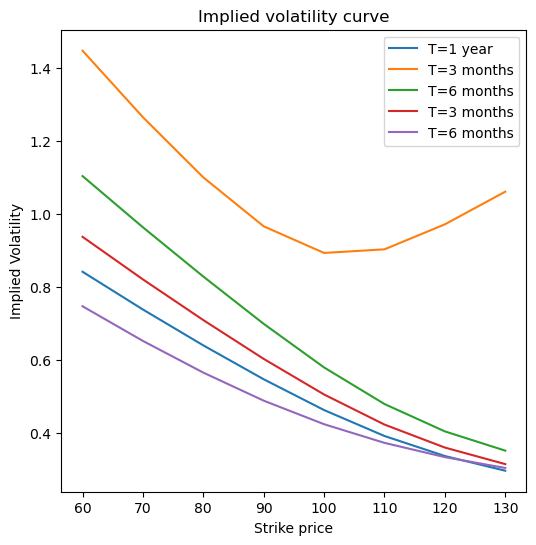

In [330]:
strike=np.array(range(60,140,10))

plt.figure(figsize=(6,6))
plt.plot(strike,impl_vol(strike,1.0),label="T=1 year")
plt.plot(strike,impl_vol(strike,0.25),label="T=3 months")
plt.plot(strike,impl_vol(strike,0.5),label="T=6 months")
plt.plot(strike,impl_vol(strike,0.75),label="T=3 months")
plt.plot(strike,impl_vol(strike,1.5),label="T=6 months")
plt.xlabel("Strike price")
plt.ylabel("Implied Volatility")
plt.title("Implied volatility curve")
plt.legend() 
plt.show()


We will now create a volatility surface using by interpolating for variances from the SVI model for different maturity. We use a linear model to interpolate between different maturities. For example if we know the volatility curves at times $T_1$ and $T_2$, we can use 

$\sigma^2(T) = \frac{T_2-T}{T_2-T_1} \sigma^2(T_1) + \frac{T-T_1}{T_2-T_1} \sigma^2(T_2)$

to calculate the model variance at time T. The variance is linked to the volatility by $variance= impliedvolatiltiy^2 * maturity $


In [199]:
def return_vol(strike,maturity):

    k=np.log(strike/S)
    
    for T in sorted(df["maturity"].unique()):

        if T==maturity:
            a,b,rho,m,sig= SVI_pred(maturity)
            return np.sqrt((a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sig**2)))/T)
            
        if T< maturity:
            lower=T
        elif T>maturity:
            upper=T
     
    
    a,b,rho,m,sig= SVI_pred(lower)
    
    var1 = a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sig**2))

    a,b,rho,m,sig= SVI_pred(upper)
    
    var2 = a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sig**2))
    
    #interpolate between the two variances
    weight1= (upper-maturity)/(upper-lower)
    weight2= (maturity-lower)/(upper-lower)

    var = weight1*var1 + weight2*var2
    
    return np.sqrt(var/maturity)
    

Now lets plot the implied volatility surface. 

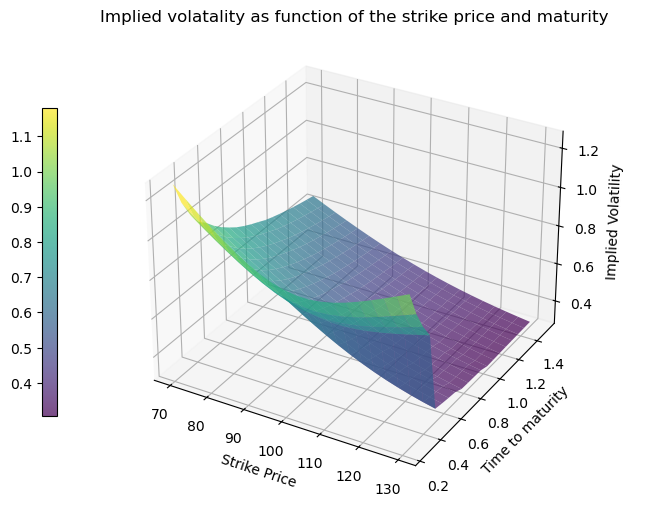

In [37]:
S_range=np.linspace(70, 130, 20)
T_range=np.linspace(0.25,1.50, 20)

S_mesh, T_mesh = np.meshgrid(S_range, T_range)

vol_surf=[]

for i in range(len(S_range)):
    for j in range(len(T_range)):

        #vol_surf.append(return_vol(S_range[i],T_range[j]))
        vol_surf.append(return_vol(S_mesh[i,j],T_mesh[i,j]))

vol_surf=np.array(vol_surf).reshape(S_mesh.shape)

fig=plt.figure(figsize=(8,10))
ax = fig.add_subplot(111, projection='3d')
function=ax.plot_surface(S_mesh,T_mesh,vol_surf,  cmap='viridis', alpha=0.7)
ax.set_title("        Implied volatality as function of the strike price and maturity       ")
ax.set_xlabel("Strike Price")
ax.set_ylabel("Time to maturity")
ax.set_zlabel("Implied Volatility")
fig.colorbar(function, shrink=0.4, location='left')
plt.show()

In [224]:
def option_price(strike, maturity, option_type):

    sigma=return_vol(strike, maturity)

    return BlackScholes_price(S, strike, maturity, r, y, sigma, option_type)

In [226]:
option_price(107,0.67,"call")

5.1201167187461

# Implied volatility during covid crash 

In this section, we are going to look at how the implied volatility changed during the covid crash of 2020. Below we will look at the SPY data from Q1 2020 to Q4 2022. 

In [281]:
data=pd.read_csv("spy_2020_2022.csv")

data.shape

(3589079, 33)

In [51]:
data.columns

Index(['[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]',
       ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]',
       ' [STRIKE_DISTANCE]', ' [STRIKE_DISTANCE_PCT]'],
      dtype='object')

This has a lot of information that is not really relevant for us. We will only keep columns that are important.

In [284]:
keep_cols=[' [QUOTE_DATE]',' [EXPIRE_DATE]',' [UNDERLYING_LAST]', ' [DTE]' , ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]']

data=data[keep_cols]
data.head()

,[QUOTE_DATE],[EXPIRE_DATE],[UNDERLYING_LAST],[DTE],[C_BID],[C_ASK],[STRIKE],[P_BID],[P_ASK]
0,2021-09-01,2021-09-01,451.85,0.0,181.090000,182.310000,270.0,0.000000,0.010000
1,2021-09-01,2021-09-01,451.85,0.0,176.090000,177.310000,275.0,0.000000,0.010000
2,2021-09-01,2021-09-01,451.85,0.0,171.090000,172.310000,280.0,0.000000,0.010000
3,2021-09-01,2021-09-01,451.85,0.0,166.140000,167.300000,285.0,0.000000,0.010000
4,2021-09-01,2021-09-01,451.85,0.0,161.090000,162.310000,290.0,0.000000,0.010000


Lets do some cleaning and re-arranging. We have to make sure that the columns have the correct datatype. Also lets drop any Nan's from the dataset. Additionaly we will make sure the bid ask prices are sensible and drop maturities over 100 days 

In [309]:
data_clean=data.copy()

data_clean[' [QUOTE_DATE]'] = pd.to_datetime(data[' [QUOTE_DATE]'], errors='coerce')
data_clean[' [EXPIRE_DATE]'] = pd.to_datetime(data[' [EXPIRE_DATE]'], errors='coerce')

numeric_cols = [' [UNDERLYING_LAST]', ' [DTE]' , ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]']

for col in numeric_cols:
    data_clean[col] = pd.to_numeric(data_clean[col],errors='coerce')
    
data_clean.dropna(inplace=True)

data_clean=data_clean[(data_clean[' [C_BID]'] > 0) & (data_clean[' [C_BID]']<data_clean[' [C_ASK]'])]
data_clean=data_clean[(data_clean[' [P_BID]'] > 0) & (data_clean[' [P_BID]']<data_clean[' [P_ASK]'])]

data_clean=data_clean[(data_clean[' [DTE]']>0) & (data_clean[' [DTE]']<=100)]

data_clean.shape

(1625745, 9)

We are only interested in comparing data before and during the covid crash. For covid, we will consider dates between '2020-03-01' and '2020-04-01' whereas before covid we will consider dates before '2020-02-01'. We will then choose a random date from the above data for our computation of implied volatilities. We will look at **call options** right now.

In [487]:
data_covid=data_clean[(data_clean[' [QUOTE_DATE]']>='2020-03-01') & (data_clean[' [QUOTE_DATE]']<='2020-04-01')]

covid_date=np.random.choice(data_covid[' [QUOTE_DATE]'].unique())

data_for_date=data_covid[data_covid[' [QUOTE_DATE]']==covid_date]

df_covid=pd.DataFrame({"strike_price":data_for_date[' [STRIKE]'],"maturity":data_for_date[' [DTE]']/365})

df_covid["market_price"]=(data_for_date[' [C_BID]']+data_for_date[' [C_ASK]'])/2
df_covid["option_type"]="call"

df_covid=df_covid.reset_index().drop(["index"],axis=1)

S_covid=data_for_date[' [UNDERLYING_LAST]'].unique()[0]



data_before_covid=data_clean[(data_clean[' [QUOTE_DATE]']<='2020-02-01')]

date=np.random.choice(data_before_covid[' [QUOTE_DATE]'].unique())

data_for_date=data_before_covid[data_before_covid[' [QUOTE_DATE]']==date]

df_normal=pd.DataFrame({"strike_price":data_for_date[' [STRIKE]'],"maturity":data_for_date[' [DTE]']/365})

df_normal["market_price"]=(data_for_date[' [C_BID]']+data_for_date[' [C_ASK]'])/2
df_normal["option_type"]="call"

df_normal=df_normal.reset_index().drop(["index"],axis=1)

S_normal=data_for_date[' [UNDERLYING_LAST]'].unique()[0]




Lets also pick some random maturities before and during covid crash to make the computations easier. 

In [489]:
covid_mat=np.random.choice(df_covid["maturity"].unique(),size=3)

normal_mat=np.random.choice(df_normal["maturity"].unique(),size=3)

df_covid=df_covid[df_covid["maturity"].isin(covid_mat)]
df_normal=df_normal[df_normal["maturity"].isin(normal_mat)]

df_covid=df_covid.reset_index().drop(["index"],axis=1)
df_normal=df_normal.reset_index().drop(["index"],axis=1)

Next lets calculate the volatilities for the above data using the functions we described earlier. 

In [491]:
S=S_covid
volatility_calculator(df_covid)

In [ ]:
S=S_normal
volatility_calculator(df_normal)

Lets now plot the volatility as a function of the strikes before and during the crash. 

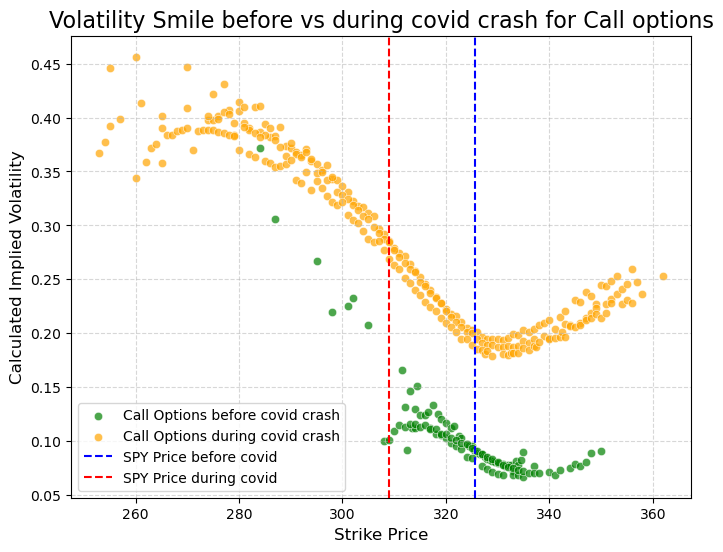

In [511]:
import seaborn as sns


plt.figure(figsize=(8, 6))
sns.scatterplot(x='strike_price', y='imp_vol', data=df_normal, label='Call Options before covid crash', color='green', alpha=0.7)
sns.scatterplot(x='strike_price', y='imp_vol', data=df_covid, label='Call Options during covid crash', color='orange', alpha=0.7)
plt.axvline(x=S_normal, color='blue', linestyle='--', label=f'SPY Price before covid')
plt.axvline(x=S_covid, color='red', linestyle='--', label=f'SPY Price during covid')
plt.title('Volatility Smile before vs during covid crash for Call options', fontsize=16)
plt.xlabel('Strike Price', fontsize=12)
plt.ylabel('Calculated Implied Volatility', fontsize=12)
plt.legend()
plt.show()


We see that the implied volatility was much higher during the covid crash than before as expected. It jumped to around **25-30 %** for at-the-money call options from the baseline of **5-10%** before the crash. For deep ITM calls the IV jumped to around **40-45%** . This is expected since deep-ITM calls follow the stock price and the market was pricing in the expected downward move.

One can also see that the before the crash, the smile is relatively flat which then becomes steep and rising upward mostly to the left during the crash. This shows that the market crash was seen as a directionally downward move. 

Lets try to look at **put options** as well ! 

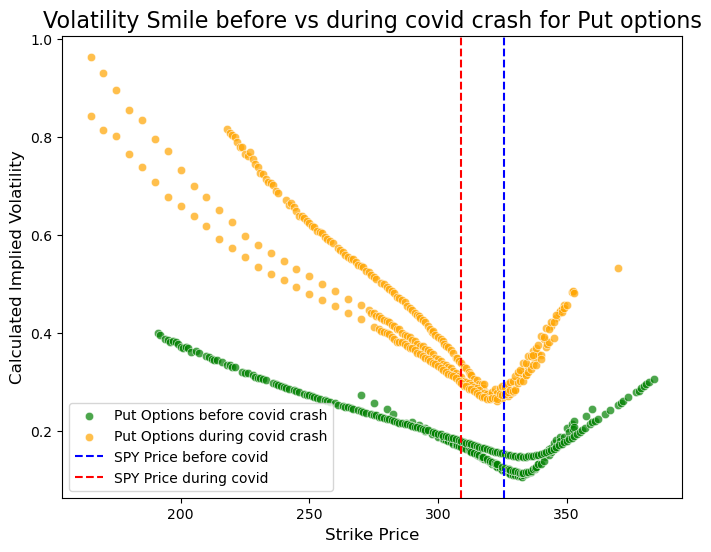

In [521]:

data_for_date=data_covid[data_covid[' [QUOTE_DATE]']==covid_date]

df_covid=pd.DataFrame({"strike_price":data_for_date[' [STRIKE]'],"maturity":data_for_date[' [DTE]']/365})

df_covid["market_price"]=(data_for_date[' [P_BID]']+data_for_date[' [P_ASK]'])/2
df_covid["option_type"]="put"

df_covid=df_covid.reset_index().drop(["index"],axis=1)

S_covid=data_for_date[' [UNDERLYING_LAST]'].unique()[0]



data_for_date=data_before_covid[data_before_covid[' [QUOTE_DATE]']==date]

df_normal=pd.DataFrame({"strike_price":data_for_date[' [STRIKE]'],"maturity":data_for_date[' [DTE]']/365})

df_normal["market_price"]=(data_for_date[' [P_BID]']+data_for_date[' [P_ASK]'])/2
df_normal["option_type"]="put"

df_normal=df_normal.reset_index().drop(["index"],axis=1)

S_normal=data_for_date[' [UNDERLYING_LAST]'].unique()[0]



covid_mat=np.random.choice(df_covid["maturity"].unique(),size=3)

normal_mat=np.random.choice(df_normal["maturity"].unique(),size=3)

df_covid=df_covid[df_covid["maturity"].isin(covid_mat)]
df_normal=df_normal[df_normal["maturity"].isin(normal_mat)]

df_covid=df_covid.reset_index().drop(["index"],axis=1)
df_normal=df_normal.reset_index().drop(["index"],axis=1)

S=S_covid
volatility_calculator(df_covid)

S=S_normal
volatility_calculator(df_normal)


plt.figure(figsize=(8, 6))
sns.scatterplot(x='strike_price', y='imp_vol', data=df_normal, label='Put Options before covid crash', color='green', alpha=0.7)
sns.scatterplot(x='strike_price', y='imp_vol', data=df_covid, label='Put Options during covid crash', color='orange', alpha=0.7)
plt.axvline(x=S_normal, color='blue', linestyle='--', label=f'SPY Price before covid')
plt.axvline(x=S_covid, color='red', linestyle='--', label=f'SPY Price during covid')
plt.title('Volatility Smile before vs during covid crash for Put options', fontsize=16)
plt.xlabel('Strike Price', fontsize=12)
plt.ylabel('Calculated Implied Volatility', fontsize=12)
plt.legend()
plt.show()


The put options show similar behavior to the call options i.e. they have a much higher IV during the market crash. Also for deep OTM puts, the implied volatility rose to **80-100%**, significantly higher than the calls. Deep OTM puts pay off heavily during the crash, which explains the IV since the market was pricing in huge downward moves

Also notice the much higher skew during the crash for the puts and the asymmetric distribution towards the left.  